In [ ]:
!pip install stockstats

In [ ]:

import pandas as pd
from stockstats import StockDataFrame as Sdf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime

original_data = pd.read_csv("2020_V1.csv")
original_data.dropna()
stock = Sdf.retype(original_data)

#data.hist()
plt.figure(figsize=(20,25))
plt.plot(original_data['open'])
plt.plot(original_data['volume'])
plt.plot(stock['rsi_14'])
plt.show()

FileNotFoundError: ignored

# Moving average forecast

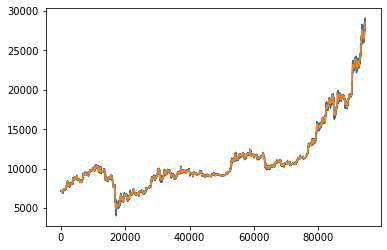

18793.831106416503
81.87261798295695


In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

series = original_data['close']
window = 100
moving_avg = moving_average_forecast(original_data['close'], window)

series.plot()
plt.plot(moving_avg)
plt.show()

print(keras.metrics.mean_squared_error(series[:-window], moving_avg).numpy())
print(keras.metrics.mean_absolute_error(series[:-window], moving_avg).numpy())

# Deep Neural Networks (DNN) one layer, linear regression

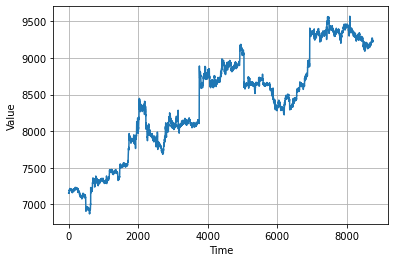

In [ ]:
sampleMonth = 8760
data = original_data['close'].head(sampleMonth * 2).to_numpy()

time = np.arange(sampleMonth * 2, dtype="float32")

split_time = sampleMonth

time_train = time[:split_time]
x_train = data[:split_time]

time_valid = time[split_time:]
x_valid = data[split_time:]

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
plot_series(time_train, x_train)

window_size = int(sampleMonth * 0.014)
batch_size = int(sampleMonth * 0.022)
shuffle_buffer_size = split_time

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# these parameters are manually tuned. No idea how to set them other than experiment
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipvalue=0.5))
model.fit(dataset,epochs=10,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.12076347],
       [-0.21938148],
       [-0.2046625 ],
       [-0.13316718],
       [ 0.20669276],
       [ 0.1784654 ],
       [ 0.18901268],
       [ 0.15243262],
       [ 0.02500634],
       [-0.22785488],
       [-0.12325652],
       [ 0.20213223],
       [-0.03878021],
       [ 0.00533298],
       [-0.02897851],
       [ 0.092254  ],
       [-0.13887283],
       [ 0.19530696],
       [ 0.04269853],
       [ 0.07923989],
       [-0.15747559],
       [-0.04067837],
       [ 0.03337539],
       [ 0.12749235],
       [ 0.1806027 ],
       [-0.08356005],
       [-0.03031544],
       [ 0.06375343],
       [ 0.15981585],
       [-0.11231486],
       [-0.14494804],
       [ 0.17162925],
       [ 0.0581989 ],
       [ 0.07521291],
       [-0.02107852],
       [-0.0726286 ],
       [-0.0495933 ],
       [-0.11869629],
       [-0.12982178],
       [ 0.15740427],
       [-0.05129546],
       [ 0.14697137],
       [-0.03113879],
       [-0.19959703],
       [ 0.022264

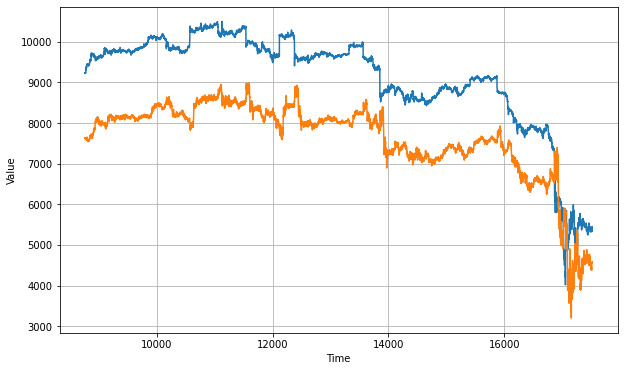

In [ ]:
forecast = []

for t in range(len(data) - window_size):
    predict = model.predict(data[t:t + window_size][np.newaxis])
    forecast.append(predict)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1495.5037